In [41]:
import genome
from genome import Genom, Node, crossover
import numpy as np
import operator
import copy
from time import sleep
import gymnasium as gym
import torch
from operator import itemgetter
import random

In [42]:
env = gym.make("CartPole-v1")

In [43]:
genom = Genom(2,1)

In [44]:
genom.p_nodes()
genom.p_connections()

===== Input Nodes =====
Key: -2 Type: input Bias: 0.37773149176688603
Key: -1 Type: input Bias: -0.6176802472612708
===== Hidden Nodes =====
===== Output Nodes =====
Key: 0 Type: out Bias: -0.17960965266590964

===== Connections =====
-2 --> 0 Weight: 0.1481579288661978 is active : True
-1 --> 0 Weight: -0.09316383636033716 is active : True



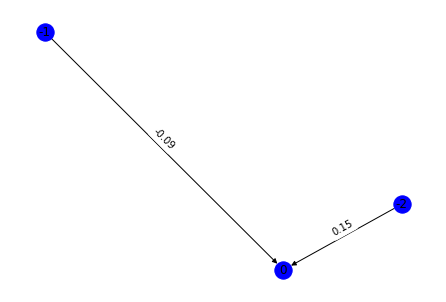

In [45]:
genom.visualize()

In [46]:
genom.forward([1,1])

[(0, -0.19071583585937593)]

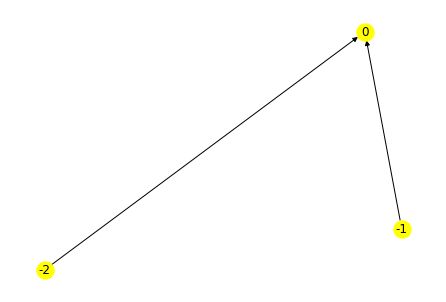

In [47]:
for _ in range(10):
    genom.mutate()
genom.visualize(labels=False, color="yellow")

In [48]:
genom.p_nodes()
genom.p_connections()

===== Input Nodes =====
Key: -2 Type: input Bias: 0.2390278523282632
Key: -1 Type: input Bias: -0.7988858266217511
===== Hidden Nodes =====
===== Output Nodes =====
Key: 0 Type: out Bias: -0.6249565694881435

===== Connections =====
-2 --> 0 Weight: -0.09962103756406333 is active : True
-1 --> 0 Weight: 0.14849985403554516 is active : True



In [49]:
genom.forward([1,1])

[(0, -1.3434809538048522)]

In [50]:
# def same_connection(con1,con2):
#         return con1.in_Node.key == con2.in_Node.key and con1.out_Node.key == con2.out_Node.key

# def contains_connection(con,l_cons):
#     for c in l_cons:
#         if same_connection(c,con):
#             return True
        
#     return False

In [51]:
# def crossover(genom1,genom2):

#         con1 = genom1.connections
#         con2 = genom2.connections

#         fit1 = np.random.rand(1)
#         fit2 = np.random.rand(1)


#         new_con = []
#         for c1 in con1:
#             for c2 in con2:
#                 if same_connection(c1,c2):
#                     if c1.is_active == c2.is_active:
#                         if np.random.rand(1) < 0.5:
#                             new_con.append(c1)
#                         else:
#                             new_con.append(c2)
#                         break
#                     elif fit1 >= fit2:
#                         new_con.append(c1)
#                     else:
#                         new_con.append(c2)

#         if fit1 >= fit2:
#             for c1 in con1:
#                 if not contains_connection(c1, new_con):
#                     new_con.append(c1)
#         else:
#             for c2 in con2:
#                 if not contains_connection(c2, new_con):
#                     new_con.append(c2)

#         g = Genom(2,1)
#         g.in_Nodes = genom1.in_Nodes
#         g.out_Nodes = genom1.out_Nodes
#         g.hidden_Nodes = genom1.hidden_Nodes if fit1 > fit2 else genom2.hidden_Nodes
#         g.connections = new_con
#         g.visualize()

#         return g

In [52]:
genom1 = Genom(2,1)
genom2 = Genom(2,1)

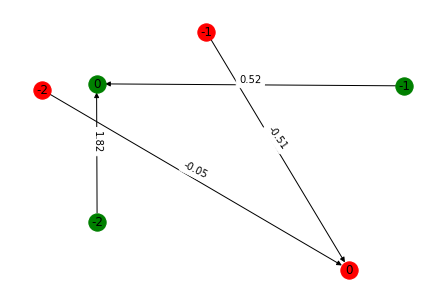

In [53]:
genom1.visualize(color="red")
genom2.visualize(color="green")

In [54]:
crossover(genom1,genom2)

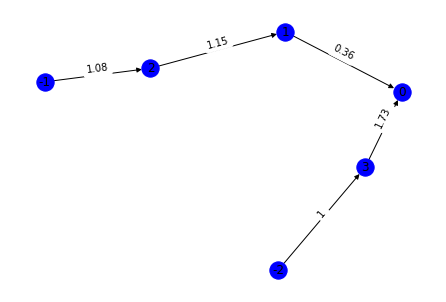

In [55]:
for _ in range(5):
    genom2.mutate()

genom2.visualize()

In [56]:
g = crossover(genom1,genom2)

In [57]:
print(g.forward([0,1]))
g.p_connections()

[(0, 2.8494314632345104)]
===== Connections =====
-2 --> 0 Weight: -0.049655704933951265 is active : True
-1 --> 0 Weight: -0.5069432018014081 is active : True
-1 --> 1 Weight: 1.164885475714505 is active : False
1 --> 0 Weight: 0.36449397058755745 is active : True
-1 --> 2 Weight: 1.0753990425479982 is active : True
2 --> 1 Weight: 1.1473239659271703 is active : True
-2 --> 3 Weight: 1 is active : True
3 --> 0 Weight: 1.733352061296966 is active : True



In [58]:
class Agent():
    
    def __init__(self, obs_dim = env.observation_space.shape, n_actions = env.action_space.n, 
                 eps = 0.05, eps_dec = 1e-5, eps_min = 0.05, popSize=20):
        
        self.obs_dim = obs_dim
        self.n_actions = n_actions
        self.action_space = [i for i in range(n_actions)]
        self.eps = eps
        self.eps_dec = eps_dec
        self.eps_min = eps_min
        self.popSize = popSize
        self.population = [(Genom(4,2),0) for _ in range(self.popSize)]


    #Choose the next action, based on the current state
    def pick_action(self, state, nn):
        if np.random.random() > self.eps:
            actions = [nn.forward(state)]
            action = max(actions, key=itemgetter(1))[0][0]
        else:
            action = np.random.choice(self.action_space)
        self.eps -= self.eps_dec if self.eps > self.eps_min else 0
        return action
    
    def train(self, epochs = 100):
        self.population = self.fitness(3, self.population)
        for i in range(epochs):
            
            if i % 25 == 0:
                print("Epoch: " + str(i), end=" ")
                print("Score: " +str(self.population[0][1]))

            if(self.population[0][1] == 1):
               return self.population[0][0]
            random.shuffle(self.population)
            child_pop = []
            for i in range(0, len(self.population), 2):
                child_pop.append((crossover(self.population[i][0], self.population[i+1][0],
                                           self.population[i][1], self.population[i+1][1]), 0))
            self.mutation(child_pop)
            self.population += self.fitness(3, child_pop)

            self.selection()

        return self.population[0][0]
            

    #Calculates the fitness of a population. The fitness is the average score after "reps" games 
    def fitness(self, reps, pop):
        new_pop = []
        for p in pop:
            sum = 0
            for _ in range(reps):
                sum += self.play(p[0])
            new_pop.append((p[0],sum/reps))
        return new_pop
    

    def selection(self):
        """Elitist Selection"""
        sortedPop = sorted(self.population, key=operator.itemgetter(1), reverse=True)
        self.population = sortedPop[:self.popSize]
            
    #mutates the childrens
    def mutation(self, children, mutate_bias = False):
        for c in children:
            c[0].mutate(prob=0.001)

    #play the game once and return the score
    def play(self, nn: Genom):
        obs, _ = env.reset()
        obs = torch.tensor(obs, dtype=torch.float)
        score = 0
        terminated = False
        truncated = False
        while not terminated and not truncated:
            action = self.pick_action(obs, nn)
            obs_, reward, terminated, truncated, _ = env.step(action)
            obs = torch.tensor(obs_, dtype=torch.float)
            score += 1
        return score
            

In [59]:
agent = Agent(popSize=20, eps=0.6)

Epoch: 0 Score: 11.333333333333334
Epoch: 25 Score: 33.0
Epoch: 50 Score: 33.0
Epoch: 75 Score: 33.0
Epoch: 100 Score: 33.0
Epoch: 125 Score: 33.0
Epoch: 150 Score: 33.0
Epoch: 175 Score: 33.0
Epoch: 200 Score: 33.0
Epoch: 225 Score: 33.0
Epoch: 250 Score: 33.0
Epoch: 275 Score: 33.0
===== Connections =====
-4 --> 0 Weight: -0.115206975171424 is active : False
-4 --> 1 Weight: 1.251567003577212 is active : False
-3 --> 0 Weight: 0.9658877725520946 is active : False
-3 --> 1 Weight: -1.032005219651323 is active : False
-2 --> 0 Weight: -0.07862400036818804 is active : False
-2 --> 1 Weight: 1.8448222830101775 is active : False
-1 --> 0 Weight: -0.4068534642796935 is active : False
-1 --> 1 Weight: -2.762625941373212 is active : False

===== Input Nodes =====
Key: -4 Type: input Bias: -2.846405452922954
Key: -3 Type: input Bias: -0.011886810360479054
Key: -2 Type: input Bias: -4.333143494384514
Key: -1 Type: input Bias: -3.001626460296771
===== Hidden Nodes =====
===== Output Nodes =====

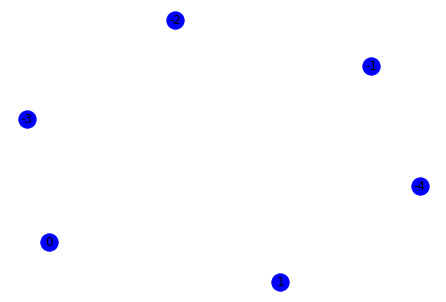

In [60]:
best = agent.train(epochs=300)
best.p_connections()
best.p_nodes()
best.visualize()

In [ ]:
class NN():

    def __init__(self, popSize = 2, n_In = 2, n_Out = 1) -> None:
        self.population = [(Genom(n_In,n_Out),0) for _ in range(popSize)] 
        self.popSize = popSize

    def forwardpass(self, index,x):
        return self.population[index][0].forward(x)

    def mutate(self,pop):
        for p in pop:
            p[0].mutate()

    def same_connection(self,con1,con2):
        return con1.in_Node.key == con2.in_Node.key and con1.out_Node.key == con2.out_Node.key

    def contains_connection(self,con,l_cons):
        for c in l_cons:
            if self.same_connection(c,con):
                return True
            
        return False
    
    def cross(self, genom1, genom2, fit1, fit2):

        con1 = genom1.connections
        con2 = genom2.connections


        new_con = []
        for c1 in con1:
            for c2 in con2:
                if self.same_connection(c1,c2):
                    if c1.is_active == c2.is_active:
                        if np.random.rand(1) < 0.5:
                            new_con.append(c1)
                        else:
                            new_con.append(c2)
                        break
                    elif fit1 >= fit2:
                        new_con.append(c1)
                    else:
                        new_con.append(c2)

        if fit1 >= fit2:
            for c1 in con1:
                if not self.contains_connection(c1, new_con):
                    new_con.append(c1)
        else:
            for c2 in con2:
                if not self.contains_connection(c2, new_con):
                    new_con.append(c2)

        g = Genom(2,1)
        g.in_Nodes = genom1.in_Nodes
        g.out_Nodes = genom1.out_Nodes
        hidden_Nodes = []
        hidden_keys = []
        for c in new_con:
            if not c.in_Node.key in hidden_keys and c.in_Node.type == "hidden":
                hidden_keys.append(c.in_Node.key)
                hidden_Nodes.append(Node(c.in_Node.key))
            if not c.out_Node.key in hidden_keys and c.out_Node.type == "hidden":
                hidden_keys.append(c.out_Node.key)
                hidden_Nodes.append(Node(c.out_Node.key))

        g.hidden_Nodes = hidden_Nodes
        g.connections = new_con
        g.n_nodes = len(g.out_Nodes) + len(g.hidden_Nodes)
        #g.visualize()

        return g

    
    def crossover(self):
        idx = [i for i in range(len(self.population))]
        np.random.shuffle(idx)

        child_pop = []

        for i in range(0,len(idx),2):
            child_pop.append((self.cross(self.population[i][0],self.population[i+1][0],self.population[i][1],self.population[i+1][1]),0))
        return child_pop

    def selection(self):
        sortedPop = sorted(self.population, key=operator.itemgetter(1), reverse=True)
        self.population = sortedPop[:self.popSize]

    def fitness(self):
        for i in range(len(self.population)):
            tmp = 0

            if np.round(self.population[i][0].forward([0,0])[0][1]) == 0:
                tmp += 0.25
            if np.round(self.population[i][0].forward([0,1])[0][1]) == 1:
                tmp += 0.25
            if np.round(self.population[i][0].forward([1,0])[0][1]) == 1:
                tmp += 0.25
            if np.round(self.population[i][0].forward([1,1])[0][1]) == 0:
                tmp += 0.25
            #print(genom.forward([0,0]))

            t = list(self.population[i])
            t[1] = tmp
            self.population[i] = tuple(t)

            
    
    def train(self, epochs = 100):
        for i in range(epochs):
            
            print("Epoch: " + str(i), end=" ")
            print("Acc: " +str(self.population[0][1]))

            if(self.population[0][1] == 1):
               return self.population[0][0]
            '''for p in self.population:
                p[0].p_nodes()
                p[0].p_connections()'''

            child_pop = self.crossover()
            self.mutate(child_pop)
            self.population += child_pop

            self.fitness()
            self.selection()

        return self.population[0][0]
            
            

In [ ]:
nn = NN(popSize=100)
best = nn.train()
best.visualize()
